In [2]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

c:\Users\srsjd\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# TODO: define train set and test set
train_set = datasets.MNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_set = datasets.MNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

In [30]:
# TODO: define dataloader for train and test
train_loader = DataLoader(train_set, shuffle=True, batch_size=100)
test_loader = DataLoader(test_set, shuffle=True, batch_size=100)

In [3]:
import torch.nn.functional as F


class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        # TODO: define layers of your model
        self.fc1 = nn.Linear(784, 500, bias=True)
        self.fc2 = nn.Linear(500, 200, bias=True)
        self.fc3 = nn.Linear(200, 10, bias=True)

    def forward(self, x):
        # TODO: define forward for your model
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.05)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.05)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.05)
        return F.log_softmax(x, dim=1)

In [50]:
# Do not change this cell
def caluculate_acc(data, model, length):
    model.eval()
    acc = 0
    for images, label in data:
        with torch.no_grad():
            images = images.to(device)
            label = label.to(device)
            yp = model(images)
            yp = torch.nn.functional.softmax(yp, dim=1)
            yp = torch.argmax(yp, 1)
            acc += torch.sum(yp == label)
    return acc / length

In [51]:
# Do not change this cell
def train_one_epoch(model, data, optimizer, criterion, length):
    model.train()
    acc = 0
    for images, labels in data:
        imgs = torch.autograd.Variable(images).to(device)
        label = torch.autograd.Variable(labels).to(device)
        optimizer.zero_grad()
        yp = model(imgs)
        loss = criterion(yp, label)
        loss.backward()
        optimizer.step()
        yp = torch.argmax(yp, 1)
        acc += torch.sum(yp == label)
    return loss.item(), acc / length

In [53]:
import torch.optim as opt
# TODO: define your model dont forget about device :)
model = Model().to(device)

# TODO: define optimizer
optimizer = opt.Adadelta(model.parameters(), 1)

# TODO: define loss
criterion = nn.NLLLoss()

# model summary
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 500]                 392,500
├─Linear: 1-2                            [-1, 200]                 100,200
├─Linear: 1-3                            [-1, 10]                  2,010
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
Total mult-adds (M): 0.49
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.89
Estimated Total Size (MB): 1.90


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 500]                 392,500
├─Linear: 1-2                            [-1, 200]                 100,200
├─Linear: 1-3                            [-1, 10]                  2,010
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
Total mult-adds (M): 0.49
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.89
Estimated Total Size (MB): 1.90

In [35]:
# training process
val_accs = []
accs = []
best_acc = 0
for e in tqdm(range(20)):
    accs.append(train_one_epoch(model, train_loader, optimizer,
                criterion, len(train_set))[1].item())
    val_accs.append(caluculate_acc(test_loader, model, len(test_set)).item())
    if best_acc < val_accs[-1]:
        torch.save(model, "model.h5")
        best_Acc = val_accs[-1]

    # just a way to avoid pverfitting
    if val_accs[-1] > 0.99 and accs[-1] > 0.99:
        break

100%|██████████| 20/20 [04:01<00:00, 12.07s/it]


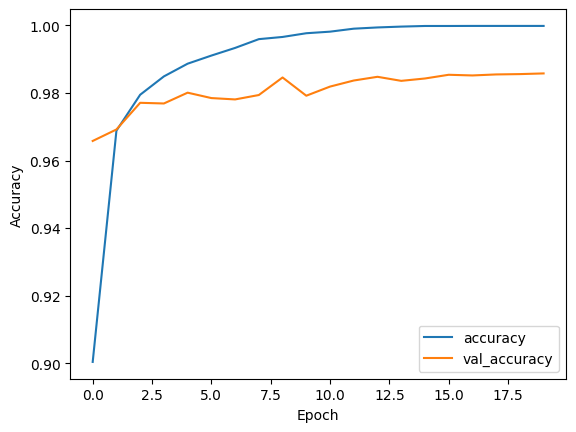

In [38]:
plt.plot(accs, label="accuracy")
plt.plot(val_accs, label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

In [39]:
caluculate_acc(test_loader, model, len(test_set)).item(), caluculate_acc(
    train_loader, model, len(train_set)
).item()

(0.9857999682426453, 0.9998833537101746)